In [91]:
import pandas as pd
import matplotlib.pyplot as plt 
import contextily as cx
from shapely.geometry.polygon import Polygon
import geopandas as gpd
from tqdm import tqdm
import warnings
import osmnx as ox


from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
import ast

warnings.filterwarnings('ignore')

In [160]:
gdf = gpd.read_file('../data/noise_cph_frb.json')


# Casting to new epsg in order to use meters in the buffer zone
gdf = gdf.to_crs(epsg=25832)

In [109]:
list(gdf)

['id', 'weighted_noise', 'betweenness']

In [161]:
gdf = gdf[["id", "weighted_noise", 'betweenness']]

In [30]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')
# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)
edges.head()

In [162]:
# Convert string to tuple and create new columns 'u' and 'v'
gdf['id_tuple'] = gdf['id'].apply(ast.literal_eval)
gdf['u'] = gdf['id_tuple'].apply(lambda x: x[0])
gdf['v'] = gdf['id_tuple'].apply(lambda x: x[1])
gdf['key'] = gdf['id_tuple'].apply(lambda x: x[2])
# Drop the temporary 'id_tuple' column if needed
gdf.drop(columns=['id_tuple'], inplace=True)

In [163]:
gdf = gdf.merge(edges, how = "right", on=["u","v","key"])

In [164]:
gdf.fillna(0, inplace=True)

In [170]:
list(gdf)

['id',
 'weighted_noise',
 'betweenness',
 'u',
 'v',
 'key',
 'osmid',
 'oneway',
 'name',
 'highway',
 'maxspeed',
 'length',
 'geometry',
 'lanes',
 'bridge',
 'ref',
 'service',
 'width',
 'access',
 'tunnel',
 'junction']

In [171]:
import pandas as pd

columns = ['highway', 'bridge', 'maxspeed', 'width', 'lanes']
for column in columns:
    gdf[column] = gdf[column].apply(lambda x: x[0] if isinstance(x, list) else x)



gdf = pd.get_dummies(gdf, columns=['highway', 'oneway', 'bridge'])


In [197]:
features = [
    'length', 
    'betweenness', 
    'maxspeed', 
    'length', 
    'lanes',  
    'width',
    'highway_residential',
    'highway_secondary',
    'highway_secondary_link',
    'highway_service',
    'highway_tertiary',
    'highway_tertiary_link',
    'highway_track',
    'highway_trunk',
    'highway_trunk_link',
    'highway_unclassified',
    'oneway_False',
    'oneway_True',
    'bridge_0',
    'bridge_boardwalk',
    'bridge_yes'
]
target = 'weighted_noise'

In [196]:
gdf['width'] = pd.to_numeric(gdf['width'], errors='coerce')


In [186]:
gdf = gdf.drop(columns=["id"])

In [199]:
# Separate rows with and without the target feature
train_data = gdf[gdf[target] > 0.0]
test_data = gdf[gdf[target] == 0.0]

X_train = train_data[features]
y_train = train_data[target]


X_test = test_data[features]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [201]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [202]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = model.score(X_val, y_val)
print(f"RMSE: {rmse}, MAE: {mae}, r2: {r2}")



RMSE: 3.793034474706355, MAE: 2.690140413531485, r2: 0.5750458033882699


In [203]:
# Predict the missing values
predictions = model.predict(X_test)

# Assign the predicted values back to the test_data
test_data[target] = predictions

In [207]:
ny = test_data[["weighted_noise", "geometry"]]

In [214]:
list(ny)

['weighted_noise', 'geometry']

In [215]:
gdf = gpd.GeoDataFrame(ny, geometry=ny.geometry)
gdf.set_crs(epsg=25832, inplace=True)


,weighted_noise,geometry
20,55.156587,"LINESTRING (723914.631 6174177.779, 723925.261..."
22,62.553587,"LINESTRING (723914.631 6174177.779, 723945.618..."
23,53.189139,"LINESTRING (723925.261 6174165.947, 723936.633..."
25,58.012930,"LINESTRING (723925.261 6174165.947, 723956.481..."
26,57.540988,"LINESTRING (723962.708 6174220.804, 723973.338..."
...,...,...
62434,63.592528,"LINESTRING (724148.784 6175265.946, 724160.933..."
62435,61.146452,"LINESTRING (723790.304 6174588.639, 723792.301..."
62436,65.370732,"LINESTRING (723790.304 6174588.639, 723782.760..."
62437,55.868797,"LINESTRING (719712.098 6176675.435, 719709.131..."


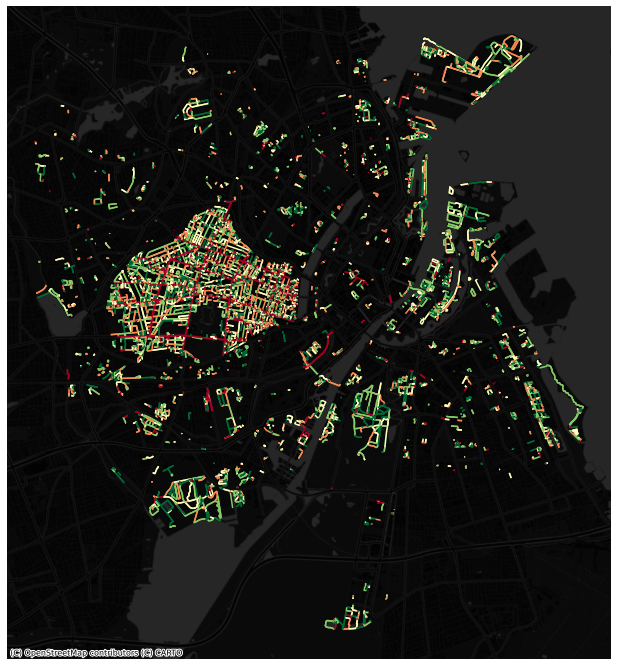

In [217]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

#plt.savefig('../pictures/street_noise_map_02.png')
